In [132]:
import os 
import json
import pickle
import datetime

import pandas as pd
from pprint import pprint
from bisect import bisect_left as find_prev
import matplotlib.pyplot as plt

import xml.etree.ElementTree as xml

strptime = datetime.datetime.strptime

In [69]:
episodes_numbers = list(map(str, range(175, 185+1)))
videos_data      = xml.parse('eastenders.collection.xml').getroot().findall("./VideoFile")

episodes_filenames = {v.find('id').text : v.find('filename').text
                      for v in videos_data
                      if v.find('id').text in episodes_numbers}
episodes_filenames

{'175': '5531550228324592939.mp4',
 '176': '5534228999422914578.mp4',
 '177': '5539381671692122744.mp4',
 '178': '5542003749222140011.mp4',
 '179': '5544574287152993687.mp4',
 '180': '5544620672795594434.mp4',
 '181': '5547193787702629969.mp4',
 '182': '5549784941472309008.mp4',
 '183': '5552368364300855101.mp4',
 '184': '5555325449284154780.mp4',
 '185': '5555360238519252381.mp4'}

In [118]:
shots_starts = {}
shots_ends = {}
shots_ids = {}

for line in open('eastenders.masterShotReferenceTable.txt', 'r'):
    line = line.strip()
    if not line: continue
    file = line.split()[0].strip()
    if file in episodes_numbers:
        file = episodes_filenames[file]
        if file not in shots_starts: 
            shots_starts[file] = []
            shots_ends[file] = []
            shots_ids[file] = []
        _, shot_id, start, end = line.split()
        ref = datetime.datetime(1900, 1, 1)
        start = (strptime(start[1:12], '%H:%M:%S:%f') - ref).total_seconds()
        end   = (strptime(end[1:12], '%H:%M:%S:%f') - ref).total_seconds()

        shots_starts[file].append(start)
        shots_ends[file].append(end)
        shots_ids[file].append(int(shot_id.split('_')[1]))

In [71]:
shots_starts['5555360238519252381.mp4'][:3], shots_ends['5555360238519252381.mp4'][:3], shots_ids['5555360238519252381.mp4'][:3]

([0.0, 0.04, 0.1], [0.03, 0.09, 1.04], ['shot185_1', 'shot185_2', 'shot185_3'])

In [72]:
data = []
for filename in os.listdir('../facerec_out/2.challenge_people'):
    j = json.load(open('../facerec_out/2.challenge_people/'+filename, 'r'))
    for rec in j:
        d = {}
        d['file'] = filename.replace('json', 'mp4')
        d['confidence'] = rec['confidence']
        d['frame'] = rec['frame']
        d['second'] = rec['npt']
        d['character'] = rec['name']
        data.append(d)

In [73]:
df = pd.DataFrame(data)
df.head()

,file,confidence,frame,second,character
0,5555360238519252381.mp4,0.647979,1525,61.0,Stacey Branning
1,5555360238519252381.mp4,0.718986,1600,64.0,Stacey Branning
2,5555360238519252381.mp4,0.444640,1650,66.0,Ryan Malloy
3,5555360238519252381.mp4,0.417089,1675,67.0,Janine Malloy
4,5555360238519252381.mp4,0.497558,2850,114.0,Stacey Branning


In [74]:
df.describe()

,confidence,frame,second
count,63541.000000,63541.000000,63541.000000
mean,0.532596,83918.442816,3356.737713
std,0.128893,49404.893461,1976.195738
min,0.333333,75.000000,3.000000
25%,0.436670,39425.000000,1577.000000
50%,0.503420,84300.000000,3372.000000
75%,0.593652,123700.000000,4948.000000
max,0.943031,179500.000000,7180.000000


In [197]:
df_cut = df[df.confidence > 0.6]

In [198]:
df_cut.describe()

,confidence,frame,second
count,15164.000000,15164.000000,15164.000000
mean,0.722718,84728.348391,3389.133936
std,0.093028,49935.467013,1997.418681
min,0.600004,225.000000,9.000000
25%,0.639010,39193.750000,1567.750000
50%,0.700766,85512.500000,3420.500000
75%,0.802882,126900.000000,5076.000000
max,0.943031,178675.000000,7147.000000


In [199]:
df_cut.character.unique()

array(['Stacey Branning', 'Ryan Malloy', 'Janine Malloy'], dtype=object)

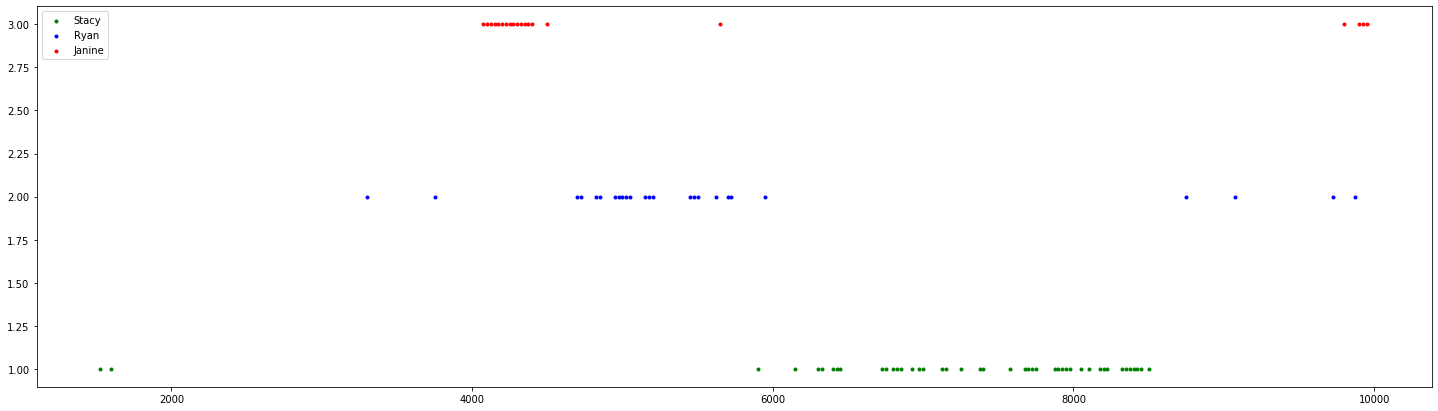

In [200]:
appearances = {'Stacey Branning':[], 'Ryan Malloy':[], 'Janine Malloy':[]}
for i, e in df_cut[df_cut.file == '5555360238519252381.mp4'].iterrows():
    if e['frame'] < 10000:
        appearances[e['character']].append(e['frame'])

fig, ax = plt.subplots(figsize=(25,7))

ax.scatter(appearances['Stacey Branning'], [1]*len(appearances['Stacey Branning']), marker='.',
        color='green',  label='Stacy')
ax.scatter(appearances['Ryan Malloy'], [2]*len(appearances['Ryan Malloy']),marker='.',
        color='blue',  label='Ryan')
ax.scatter(appearances['Janine Malloy'], [3]*len(appearances['Janine Malloy']), marker='.',
        color='red', label='Janine')

ax.legend()
plt.show()

In [352]:
cut = 0.7
keep = 2
add = 2

In [353]:
df_cut = df[df.confidence > cut]

In [354]:
recs = {f:set() for f in df.file.unique()}
for i, e in df_cut.iterrows():
    file = e['file']
    k = find_prev(shots_starts[file], e['second'])
    recs[file].add(k-1)
    recs[file].add(k)
    recs[file].add(k+1)
    
    if add == 2: 
        recs[file].add(k-2)
        recs[file].add(k+2)
        
    # if len(recs[file]) < 4:
    #    print(file, e['second'], k, recs[file])

In [355]:
segs = {}
for file in recs:
    seg_start = 0
    segs[file] = []
    sorted_ids = list(recs[file])
    if seg_start == 0:
        seg_start = sorted_ids[0]
        cur = sorted_ids[0]
    
    for i, e in enumerate(sorted_ids[1:]):
        if e == cur + 1:
            cur += 1
        elif i == len(recs) - 1 and e == cur + 1:
            segs[file].append((seg_start, e))
        else:
            if cur - seg_start > (0 if keep == 'all' else (keep * 2 + 1)):
                segs[file].append((seg_start, cur))
            seg_start = e
            cur = e

In [356]:
# if I keep everything
s = """5555360238519252381.mp4 100
5531550228324592939.mp4 128
5544620672795594434.mp4 31
5547193787702629969.mp4 96
5549784941472309008.mp4 100
5552368364300855101.mp4 108
5555325449284154780.mp4 89
5534228999422914578.mp4 129
5542003749222140011.mp4 87
5544574287152993687.mp4 100
5539381671692122744.mp4 117"""
# print(s)
print(sum([len(segs[ep]) for ep in segs]))

416


In [357]:
timed_segs = {}
for ep in segs:
    timed_segs[ep] = []
    print(ep)
    for s, e in segs[ep]:
        try:
            timed_segs[ep].append((shots_starts[ep][s], shots_ends[ep][e]))
        except Exception as ex:
            print('@', ep, s, e)
            print(str(ex))

5555360238519252381.mp4
5531550228324592939.mp4
5544620672795594434.mp4
5547193787702629969.mp4
5549784941472309008.mp4
5552368364300855101.mp4
5555325449284154780.mp4
5534228999422914578.mp4
5542003749222140011.mp4
5544574287152993687.mp4
5539381671692122744.mp4


In [358]:
pickle.dump(timed_segs, open(f'segs/segments_add{add}_keep{keep}_cut{cut}.pickle', 'wb'))